In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Dataset

In [5]:
#Abbiamo 1797 campioni, ciascuno 8x8. Ogni immagine è organizzata come un vettore di 64 pixel
digits_dataset = load_digits()

print(digits_dataset.data.shape)

(1797, 64)


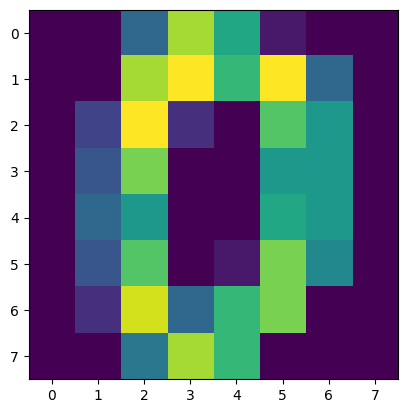

In [6]:
from matplotlib import pyplot as plt
#ogni riga è una immagine. Vediamo un esempio
img1 = digits_dataset.data[0]
#facciamo il reshape del vettore di 64 elementi in 8x8
img1 = np.reshape(img1, (8,8))
plt.imshow(img1)


In [7]:
#essendo ogni riga una immagine allora prendo le prime 1000 come training set, 350 come validation set e il resto come test set
training_data = digits_dataset.data[0:1000].astype(np.float32)
validation_data = digits_dataset.data[1000:1350].astype(np.float32)
test_data = digits_dataset.data[1350:].astype(np.float32)

Non alleneremo la rete dandole tutti i dati, ma batch dopo batch. Creiamo quindi un DataLoader che semplicemente dividerà i dati in batch da 64 immagini (dopo averli mischiati) e ci restituirà, quando richiesto, un batch alla volta.

In [8]:
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# Model

Hyperparameters

In [9]:
#lunghezza di ogni immagine flattata. Essendo 8x8 --> 64
length_flatted_image = 64

#numero di hidden neuron nella rete scala s() e traslazione t()
number_of_neurons_for_scale_and_translation_network = 256

#numero di distribuzioni per approssimare la p(x) reale
number_of_flows = 8



Scale and translation network

In [10]:
class Scale_Net(nn.Module):
  def __init__(self, input_dimension, number_of_neurons_for_scale_and_translation_network):
    super(Scale_Net, self).__init__()

    #divideremo l'input in due parti uguali, quindi la scale net prenderà in ingresso
    #la metà delle componenti
    self.input_dimension = input_dimension // 2 
    self.number_of_neurons = number_of_neurons_for_scale_and_translation_network

    #indico i layer
    self.linear_layer_1 = nn.Linear(self.input_dimension, self.number_of_neurons)
    self.leaky_relu = nn.LeakyReLU()
    self.linear_layer_2 = nn.Linear(self.number_of_neurons, self.number_of_neurons)
    self.linear_layer_3 = nn.Linear(self.number_of_neurons, self.input_dimension)
    self.tanh = nn.Tanh()

  def forward(self,x):
    x = self.linear_layer_1(x)
    x = self.leaky_relu(x)
    x = self.linear_layer_2(x)
    x = self.leaky_relu(x)
    x = self.linear_layer_3(x)
    x = self.tanh(x)

    return x



class Translation_Net(nn.Module):
  def __init__(self, input_dimension, number_of_neurons_for_scale_and_translation_network):
    super(Translation_Net, self).__init__()

    #divideremo l'input in due parti uguali, quindi la translation net prenderà in ingresso
    #la metà delle componenti
    self.input_dimension = input_dimension // 2 
    self.number_of_neurons = number_of_neurons_for_scale_and_translation_network

    #indico i layer
    self.linear_layer_1 = nn.Linear(self.input_dimension, self.number_of_neurons)
    self.leaky_relu = nn.LeakyReLU()
    self.linear_layer_2 = nn.Linear(self.number_of_neurons, self.number_of_neurons)
    self.linear_layer_3 = nn.Linear(self.number_of_neurons, self.input_dimension)

  def forward(self,x):
    x = self.linear_layer_1(x)
    x = self.leaky_relu(x)
    x = self.linear_layer_2(x)
    x = self.leaky_relu(x)
    x = self.linear_layer_3(x)

    return x



Starting distribution p0

In [11]:
p0 = torch.distributions.MultivariateNormal(torch.zeros(length_flatted_image), torch.eye(length_flatted_image))

RealNVP module

In [83]:
class RealNVP(nn.Module):
  def __init__(self, Scale_net, Translation_net, number_of_flows, p0, length_flatted_image, number_of_neurons_for_scale_and_translation_network):
    super(RealNVP, self).__init__()
    
    self.p0 = p0

    #creo un "array" di nn.Moduli contenente ciascuno le (es.) 8 scale e translation net
    self.scale_networks = torch.nn.ModuleList([Scale_Net(length_flatted_image, number_of_neurons_for_scale_and_translation_network) for _ in range(number_of_flows)]) 
    self.translation_networks = torch.nn.ModuleList([Translation_Net(length_flatted_image, number_of_neurons_for_scale_and_translation_network) for _ in range(number_of_flows)])

    self.number_of_flows = number_of_flows
    self.length_flatted_image = length_flatted_image

  '''
  index serve a indicare in quale flow siamo
  
  forward indica, se True, che da px ci stiamo muovendo verso p0 (quindi dobbiamo usare le
  funzioni inverse), altrimenti le funzioni dirette
  '''
  def coupling_layer(self, x, index, forward= True):
    '''
      NB: anche se chiamo xa e xb e poi ya e yb i nomi dipendono in realtà
      dal tipo di forwording. Se è False allora rimangono cosi, altrimenti a 
      livello "semantico" andrebbero cambiati.
    '''
    print(x.shape)
    #divido l'input in due parti
    (xa,xb) = torch.chunk(x,2,1)

    #inizializzo i due output del coupling layer
    ya = 0
    yb = 0

    #indipendentemente dal forwarding calcolo il valore di s e t
    #se siamo nel forwarding allora xa è da intendere come ya
    s = self.scale_networks[index](xa)
    t = self.translation_networks[index](xa)

    #per trovare ya (indipendentemente dal forwarding)conosco già la f1,
    # questa è la funzione identità su xa
    ya = xa

    '''
      Se sto procedendo da p0 verso px (forward=False) allora so che:
      yb = f2(xa, xb) = exp(s(xa)) Hadamard xb + t(xa)
      
    '''
    #Non essendo nella fase di forward so che gli ingressi sono xa e xb
    if forward == False:
      yb = torch.exp(s)*xb + t   
    else:
      '''
      Se sto procedendo da px verso p0 (forward=True) allora so che:
      xb = f2^-1(ya, yb) = (yb-t(ya)) Hadamard exp(-s(ya))
      Ma ripeto, qui xa e xb sono da interpretare come input
      
    '''
      yb = (xb-t)*torch.exp(-s)

    
    #ritorniamo l'output come [y_a,y_b] e anche s perchè ci servirà per il
    #calcolo della loss 
    return torch.cat((ya,yb),1), s

  def permute(self,x):
    #scambio componenti Es. da 1234 a 4321
    return x.flip(1)



  def forward(self, x):

    '''
    per il calcolo della loss dobbiamo memorizzarci per ogni immagine
    il logaritmo della jacobiana. Lo aggiorneremo ad ogni flow
    '''
    log_det_J = x.new_zeros(x.shape[0])
    output = x
    # per ogni flow...(procedendo da px verso p0)
    for flow_i in range(self.number_of_flows):
      #iniettiamo x (se siamo all'inizio) o l'output precedente e 
      #otteniamo l'output (insieme a s) dal coupling layer
      output, s = self.coupling_layer(output, flow_i, forward=True)
      #effettuiamo la permutazione
      output = self.permute(output)
      #per ogni immagine aggiorniamo il logaritmo del determinante
      log_det_J = log_det_J + s.sum(dim=1)

    '''
      Adesso in output ho l'output per ogni immagine iniettata + la somma
      dei logaritmi dei determinanti della Jacobiana in ogni flow ottenuta.
      Essendo ciascun output "l'ultima" trasformazione fatta, sarebbero le 
      componenti del vettore z0 da dare alla prior. Ottenuto il suo valore 
      abbiamo tutti gli ingredienti per calcolare la p(x)
    '''
    # La loss per ogni immagine è  -ln(p0(z0))+ sum(log_det_Ji)
    # Avendone diverse, per il batch calcolo la media (o la somma)
    mle_batch = (-self.p0.log_prob(output) + log_det_J).mean()

    #ritorno la loss
    return mle_batch


  def sample_new_data(self):
    #campiono dalla prior
    z = self.p0.sample()
    #aggiungo una dimensione per il batch cosi da poterla iniettare
    #nella rete sfruttando stavolta le funzioni dirette! 
    z = z.unsqueeze(0)
    #Inoltre devo percorrerla da sinistra verso destra, quindi cambio ordine nel for
    for flow_i in reversed(range(self.number_of_flows)):
      #stavolta effettuiamo prima la permutazione
      z = self.permute(z)
      z, _ = self.coupling_layer(z, flow_i, forward=False)
    
    #alla fine del for ho ottenuto un output nato dalla trasformazione che mi
    #riporta in campioni di px
    return z




In [84]:
model = RealNVP(Scale_Net, Translation_Net, 8, p0, 64, 256)

# Training

In [45]:
learning_rate = 0.002
#i parametri che l'optimizer deve ottimizzare sono tutti quelli del modello
parameters_to_optimize = [p for p in model.parameters() if p.requires_grad == True]

optimizer = torch.optim.Adamax(parameters_to_optimize, lr=learning_rate)

In [ ]:
import copy

number_of_epochs = 1000

#qui salvo il migliore modello, ossia quello che ha la loss sulla validazione migliore
best_model = model
best_validation_loss = 1000000

patience = 0
max_patience = 20

for epoch in range(number_of_epochs):
  model.train()
  print("Epoca "+str(epoch)+" _____________________________________________________________________")

  for index_batch, batch in enumerate(training_loader):
    #il batch ha shape 64x64. Vabbene cosi (64,64) in quanto Linear vuole questo formato
    #ottengo la loss sul batch corrente
    loss = model.forward(batch)

    #calcolo le derivate parziali della loss rispetto ogni parametro
    loss.backward()

    #adesso ogni parametro ha in .grad il gradiente. Aggiorno il suo valore
    optimizer.step()

    #resetto il .grad di ogni parametro (altrimenti sommo quello attuale al successivo che calcoleremo nell'epoca dopo)
    optimizer.zero_grad()

    print("   Loss: ", loss)

  #alla fine di ogni epoca, valuto come si comporta la loss col validation set
  print("   ___________________________")
  model.eval()
  validation_loss = 0
  N = 0
  for index_batch, batch in enumerate(validation_loader):
    loss_i = model.forward(batch)
    validation_loss = validation_loss + loss_i
    N = N +  batch.shape[0]

  validation_loss = validation_loss/N
  print("   Loss media validation: "+str(validation_loss))

  #se tale modello ha una loss migliore di quella attualmente migliore..
  if validation_loss < best_validation_loss:
    patience = 0
    best_validation_loss = validation_loss
    print("   la loss risulta essere migliore")
    best_model = copy.deepcopy(model)
  else:
    print("   patience= "+ str(patience+1))
    patience = patience + 1
  
  if patience > max_patience:
    print("")
    print("Patience massimo superato. Fine del training")
    break


# Sampling

In [ ]:
model.sample_new_data()